In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [ ]:
import os

if IN_COLAB:
    ! pip3 install mne
    ! pip3 install yadisk

    import yadisk

    if not os.path.exists('dataset.zip'):
        url = 'https://disk.yandex.ru/d/hItiy8VK-lk0gQ' 
        y = yadisk.YaDisk()
        y.download_public(url, 'dataset.zip')

        ! unzip dataset.zip

    if not os.path.exists('eegproject'):
        ! unzip eegproject.zip

In [ ]:
import torch
import random
import numpy as np

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(42)

In [ ]:
from eegproject.data.sequential_dataset import SequentialEEGDataset, get_short_sequence_dataset, iterate_batches
from eegproject.data.transforms import scale

In [ ]:
train_dataset_ = SequentialEEGDataset(split='train', preprocessed_path='eeg_dataset/train_eeg_dataset.pt', transform=scale)
test_dataset_ = SequentialEEGDataset(split='test', preprocessed_path='eeg_dataset/test_eeg_dataset.pt', transform=scale)

In [ ]:
from eegproject.models.cnn_classifier import CNNClassifier
from eegproject.models.lstm_classifier import LSTMClassifier
from eegproject.models.cnn_encoder import CNNEncoder
from torch.nn.utils.rnn import pad_sequence
import torch

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 16
sequence_length = 50

X_train, y_train = get_short_sequence_dataset(train_dataset_, sequence_length)
X_test, y_test = get_short_sequence_dataset(test_dataset_, sequence_length)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for X, y in train_dataloader:
    print(y)
    print(X.shape, y.shape)
    break

In [ ]:
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.to(device).train()
    cum_loss = 0
    n_objects = 0
    for features, y in tqdm(train_dataloader):
    # for features, y in tqdm(iterate_batches(train_dataset_, batch_size, sequence_length, sequence_length, 0.2)):
        features = features.to(device)
        y = y.to(device)
                
        preds = model(features, None)[0][y != -1]
        loss = criterion(preds, y[y != -1])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        cum_loss += loss.detach().cpu().numpy() * features.shape[0] * features.shape[1]
        n_objects += features.shape[0] * features.shape[1]
        
    return cum_loss / n_objects


def predict(model, test_dataloder, criterion, device="cuda:0"):
    model.to(device).eval()
    with torch.no_grad():        
        predicts = torch.tensor([])
        true_values = torch.tensor([])
        cum_loss = 0
        n_objects = 0
        for features, y in tqdm(test_dataloder):
        # for features, y in tqdm(iterate_batches(test_dataset_, batch_size, 40, 0, 0)):
            features = features.to(device)
            y = y.to(device)
            
            cur = model(features, None)[0][y != -1]
            
            predicts = torch.cat([predicts, torch.argmax(cur.cpu(), axis=1)])
            true_values = torch.cat([true_values, y[y != -1].cpu()])
            n_objects += features.shape[0] * features.shape[1]
            cum_loss += criterion(cur, y[y != -1]).cpu().item() * features.shape[0] * features.shape[1]
        
        return cum_loss / n_objects, predicts, true_values
    

def train(model, train_dataloader, test_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    for epoch in range(n_epochs):
        print('Train')
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        print('Evaluate')
        val_loss, predicted, true = predict(model, test_dataloader, criterion, device)
        if scheduler is not None:
            scheduler.step(val_loss)
            
        accuracy = accuracy_score(predicted, true)
        print('Epoch {}, val loss {:.3f}, train loss {:.3f}, accuracy {:.3f}'\
              .format(epoch + 1, val_loss, train_loss, accuracy))

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
encoder = torch.load('cnn_encoder.pt', map_location='cpu')
model = LSTMClassifier(encoder, batch_size=batch_size)

clip_value = 1.0
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

In [ ]:
optimizer = torch.optim.Adam(
    [
      {"params": model.encoder.parameters(), "lr": 1e-5},
      {"params": model.lstm.parameters(), "lr": 1e-3},
      {"params": model.mlp.parameters(), "lr": 1e-3},
    ],
    lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

In [ ]:
val_loss, predicted, true = predict(model, test_dataloader, criterion, device)
accuracy_score(predicted, true)

  0%|          | 0/65 [00:00<?, ?it/s]

0.11868383179228358

In [ ]:
train(model, train_dataloader, test_dataloader, criterion, optimizer, device, 35, scheduler)

Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1, val loss 0.581, train loss 0.616, accuracy 0.785
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2, val loss 0.572, train loss 0.546, accuracy 0.782
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3, val loss 0.569, train loss 0.514, accuracy 0.778
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4, val loss 0.583, train loss 0.516, accuracy 0.773
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5, val loss 0.538, train loss 0.499, accuracy 0.796
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6, val loss 0.554, train loss 0.501, accuracy 0.784
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7, val loss 0.541, train loss 0.491, accuracy 0.794
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8, val loss 0.551, train loss 0.493, accuracy 0.788
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 5.0000e-06.
Epoch 00009: reducing learning rate of group 1 to 5.0000e-04.
Epoch 00009: reducing learning rate of group 2 to 5.0000e-04.
Epoch 9, val loss 0.551, train loss 0.482, accuracy 0.787
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10, val loss 0.541, train loss 0.466, accuracy 0.793
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11, val loss 0.549, train loss 0.477, accuracy 0.790
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12, val loss 0.550, train loss 0.465, accuracy 0.784
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 2.5000e-06.
Epoch 00013: reducing learning rate of group 1 to 2.5000e-04.
Epoch 00013: reducing learning rate of group 2 to 2.5000e-04.
Epoch 13, val loss 0.556, train loss 0.465, accuracy 0.784
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14, val loss 0.547, train loss 0.454, accuracy 0.789
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15, val loss 0.547, train loss 0.454, accuracy 0.788
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 16, val loss 0.546, train loss 0.456, accuracy 0.788
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 1.2500e-06.
Epoch 00017: reducing learning rate of group 1 to 1.2500e-04.
Epoch 00017: reducing learning rate of group 2 to 1.2500e-04.
Epoch 17, val loss 0.544, train loss 0.459, accuracy 0.792
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 18, val loss 0.534, train loss 0.459, accuracy 0.794
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 19, val loss 0.543, train loss 0.465, accuracy 0.793
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 20, val loss 0.552, train loss 0.454, accuracy 0.787
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 21, val loss 0.538, train loss 0.456, accuracy 0.792
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 6.2500e-07.
Epoch 00022: reducing learning rate of group 1 to 6.2500e-05.
Epoch 00022: reducing learning rate of group 2 to 6.2500e-05.
Epoch 22, val loss 0.540, train loss 0.454, accuracy 0.793
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 23, val loss 0.546, train loss 0.446, accuracy 0.790
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 24, val loss 0.540, train loss 0.444, accuracy 0.792
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 25, val loss 0.539, train loss 0.451, accuracy 0.793
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00026: reducing learning rate of group 0 to 3.1250e-07.
Epoch 00026: reducing learning rate of group 1 to 3.1250e-05.
Epoch 00026: reducing learning rate of group 2 to 3.1250e-05.
Epoch 26, val loss 0.542, train loss 0.440, accuracy 0.791
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 27, val loss 0.542, train loss 0.448, accuracy 0.791
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 28, val loss 0.546, train loss 0.452, accuracy 0.791
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 29, val loss 0.542, train loss 0.445, accuracy 0.790
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 1.5625e-07.
Epoch 00030: reducing learning rate of group 1 to 1.5625e-05.
Epoch 00030: reducing learning rate of group 2 to 1.5625e-05.
Epoch 30, val loss 0.541, train loss 0.447, accuracy 0.792
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 31, val loss 0.534, train loss 0.451, accuracy 0.794
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 32, val loss 0.538, train loss 0.442, accuracy 0.794
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 33, val loss 0.543, train loss 0.450, accuracy 0.791
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00034: reducing learning rate of group 0 to 7.8125e-08.
Epoch 00034: reducing learning rate of group 1 to 7.8125e-06.
Epoch 00034: reducing learning rate of group 2 to 7.8125e-06.
Epoch 34, val loss 0.540, train loss 0.445, accuracy 0.791
Train


  0%|          | 0/177 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 35, val loss 0.537, train loss 0.447, accuracy 0.794


In [ ]:
val_loss, y_pred, y_test = predict(model, test_dataloader, criterion, device)
accuracy_score(predicted, true)

  0%|          | 0/65 [00:00<?, ?it/s]

0.7936439090747787

In [ ]:
torch.save(model, 'lstm_classifier_subsequences.pt')

In [ ]:
# Assess the results
acc = accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(acc))

Accuracy score: 0.7936439090747787


In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen kappa score: {}".format(cohen_kappa))

Cohen kappa score: 0.7205775602862408


In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average=None)
f1

array([0.90954019, 0.39842249, 0.82105856, 0.75931497, 0.76291734])

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.7922094526547623

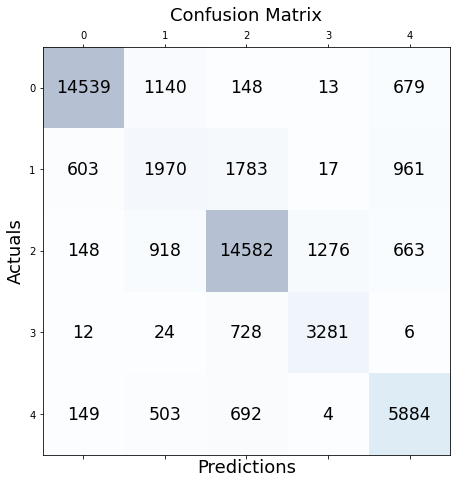

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()